In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import spotify
import utils

sp = spotify.login(scope='playlist-modify-private')
user = sp.current_user()
username = user['id']
displayName = user['display_name']
displayName

'Mehmet Birgi'

In [33]:
playlist_id = 'spotify:playlist:58B3Ezs7xBVyrVnXUEOw8B'
playlist = sp.user_playlist(username, playlist_id, fields="name, tracks, next")
playlist_name = playlist['name']
playlist_name

'Walk Test'

In [34]:
tracks = []
audio_features = []
tracks_paging_object = playlist['tracks']
while True:
    track_id_list = []
    for item in tracks_paging_object['items']:
        track_result = item['track']
        track = {
            'id': track_result['id'],
            'name': track_result['name'],
            'artist_id': track_result['artists'][0]['id'],
            'artist_name': track_result['artists'][0]['name'],
            'popularity': track_result['popularity'],
        }
        tracks.append(track)
        track_id_list.append(track['id'])
    audio_features.extend(sp.audio_features(track_id_list))
    if not tracks_paging_object['next']:
        break
    tracks_paging_object = sp.next(tracks_paging_object)
print(len(tracks), "tracks in playlist")
print(len(audio_features), "tracks in audio_features")

25 tracks in playlist
25 tracks in audio_features


In [35]:
tracks_df = pd.DataFrame(tracks)
audio_features_df = pd.DataFrame(audio_features)

df = tracks_df.merge(audio_features_df, on='id')
df = df.drop(columns=['analysis_url', 'track_href', 'type', 'uri'])
df.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,26.680000,0.678120,0.527040,4.840000,-9.643640,0.76000,0.044116,0.477002,0.062597,0.120936,0.640960,130.357240,228697.120000,3.840000
std,23.086287,0.073857,0.226044,2.967603,3.156555,0.43589,0.017873,0.338829,0.186406,0.056287,0.216005,2.800732,64197.389401,0.472582
min,0.000000,0.542000,0.110000,0.000000,-15.841000,0.00000,0.026800,0.000359,0.000000,0.043800,0.287000,125.145000,147680.000000,3.000000
25%,0.000000,0.633000,0.361000,3.000000,-12.149000,1.00000,0.031800,0.214000,0.000027,0.087100,0.466000,129.202000,182760.000000,4.000000
50%,27.000000,0.668000,0.558000,4.000000,-9.737000,1.00000,0.037600,0.497000,0.001600,0.102000,0.646000,130.738000,222373.000000,4.000000
75%,41.000000,0.704000,0.695000,7.000000,-6.908000,1.00000,0.043500,0.742000,0.015200,0.161000,0.827000,132.660000,256347.000000,4.000000
max,74.000000,0.825000,0.911000,10.000000,-4.746000,1.00000,0.091900,0.993000,0.867000,0.284000,0.966000,134.796000,429520.000000,5.000000


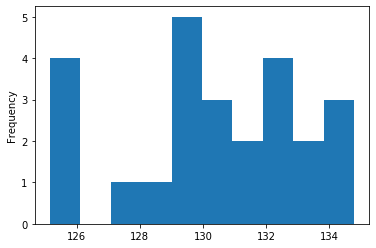

In [36]:
df['tempo'].plot.hist()

In [28]:
df[df['tempo'] > 160]

,id,name,artist_id,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
10,0WSlOSMLJWoWUpWci9nnRb,Cissy Strut,2JRvXPGWiINrnJljNJhG5s,The Meters,57,0.507,0.763,0,-12.732,1,0.0945,0.172,0.886,0.324,0.708,176.193,186853,4


<img src="bpm_pace.png" width="600">

In [19]:
# set the BPM range
tempo_min, tempo_max = 120, 130
track_ids = list(df[(df['tempo'] >= tempo_min) & (df['tempo'] <= tempo_max) & (df['danceability'] >= 0.5)]['id'])
len(track_ids)

50

In [20]:
playlist_id, is_new = spotify.get_playlist_by_name(sp, 
        f"Run Test BPM {tempo_min} - {tempo_max}", 
        create_if_none=True)
if playlist_id and is_new:
    print(f"Created new playlist with ID {playlist_id}")
elif playlist_id:
    print(f"Found existing playlist with ID {playlist_id}")
else:
    print("Something went wrong :-(")

Created new playlist with ID 1BfmdmBfylz9Xb9vo7FDNS


In [21]:
num_tracks_added = spotify.add_tracks(sp, playlist_id, track_ids)
num_tracks_added

50

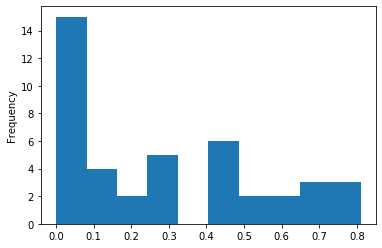

In [7]:
df['acousticness'].plot.hist()

# Get all my public playlists

In [7]:
sp_response = sp.current_user_playlists()
all_playlists = sp_response['items']
while sp_response['next']:
    sp_response = sp.next(sp_response)
    all_playlists.extend(sp_response['items'])
len(all_playlists)

73

In [8]:
own_playlists = list(filter(lambda l: l['owner']['id'] == user['id'], all_playlists))
len(own_playlists)

49

In [9]:
own_playlists_trimmed = [{k: v for k, v in d.items() if k in ['id', 'name', 'public', 'tracks']} for d in own_playlists]
len(own_playlists_trimmed)

49

In [10]:
public_playlists = list(filter(lambda l: (l['public'] == True), own_playlists_trimmed))
len(public_playlists)

17

In [11]:
public_playlists

[{'id': '6u5RL72VpPaJfeLksVLE2Q',
  'name': 'Mellow Jazz',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/6u5RL72VpPaJfeLksVLE2Q/tracks',
   'total': 712}},
 {'id': '7JYdgqlBBhiCqjpx2pVKwf',
  'name': 'KJAH',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/7JYdgqlBBhiCqjpx2pVKwf/tracks',
   'total': 1610}},
 {'id': '4jdHBhEw9a9OBJ0CVbmpFX',
  'name': 'Run',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/4jdHBhEw9a9OBJ0CVbmpFX/tracks',
   'total': 68}},
 {'id': '2MzQi9D9OtFuUsuOS8lwtS',
  'name': 'Power Songs',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/2MzQi9D9OtFuUsuOS8lwtS/tracks',
   'total': 925}},
 {'id': '5ngdqzXvg3v6yakZ6oAcxv',
  'name': 'Trojan Archives',
  'public': True,
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/5ngdqzXvg3v6yakZ6oAcxv/tracks',
   'total': 749}},
 {'id': '566s1zzyRtF4bzv9JfpnVY',
  'name': 'Pop2000',
  'public': True,
  '